# Data preprocessing

Data cleaning and aggregation part. The main dataset is Movielens' 25 million movie review dataset. IMDb's official datasets is used to enrich the main dataset with potentially relevant information such as director and writer.

In [135]:
# Libraries imports and function declarations
import pandas as pd
import numpy as np
import json
import time

In [136]:
t0 = time.time()

# 1. Movies

## Movielens dataset

Data cleaning of the films dataset.

In [137]:
def convert_genres_list(x):
    if not x:
        return np.NaN
    # If we rearch this point, it means we've got a string
    # with at least 1 genre.
    arr = x.lower().split("|")

    # For simplicity we'll only return the first 3 genres.
    # If N < 3, len(arr) = N.
    return arr[:3]

df_main = pd.read_csv(
    "datasets/ml-25m/movies.csv", sep=",",
    converters= {
        'genres': convert_genres_list
    })

In [138]:
df_main.head(2)

,movieId,title,genres
0,1,Toy Story (1995),"[adventure, animation, children]"
1,2,Jumanji (1995),"[adventure, children, fantasy]"


In [139]:
df_main.shape

(62423, 3)

In [140]:
df_main.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [141]:
df_main['title'].duplicated().all()

False

In [142]:
def process_year(movie):
    # Format: movie_name (year)
    # We'll try to get the highest index for the parenthesis.
    # If any of them are not found or the cast has an invalid input return -1 as year.
    try:
        start = movie.rindex('(')
        end = movie.rindex(')')
        
        year = int(movie[start+1:end])
        return year
    except:
        return -1    
    
df_main['year'] = df_main['title'].apply(lambda x: process_year(x))

In [143]:
-1 in df_main['year'] # All years have been successfully converted

False

In [144]:
# Delete year from name
def process_name(movie):
    # Format: movie_name (year)
    # We'll try to get the highest index for the parenthesis.
    try:
        start = movie.rindex('(')
        new_movie = movie[:start].strip()
        return new_movie
    except:
        return movie

df_main['title'] = df_main['title'].apply(lambda x: process_name(x))

In [145]:
df_main.head(5)

,movieId,title,genres,year
0,1,Toy Story,"[adventure, animation, children]",1995
1,2,Jumanji,"[adventure, children, fantasy]",1995
2,3,Grumpier Old Men,"[comedy, romance]",1995
3,4,Waiting to Exhale,"[comedy, drama, romance]",1995
4,5,Father of the Bride Part II,[comedy],1995


Once we have this dataset cleaned, we need to aggregate information from the IMDb dataset.

Informatio such as titleType, director, writer and main actors will be added.

## IMDb dataset

In [146]:
df_im = pd.read_csv(
    "datasets/IMDb/title_basics.tsv", sep="\t",
    usecols= ['tconst', 'titleType', 'primaryTitle']
    )

In [147]:
df_im.shape

(8699991, 3)

In [148]:
df_im.isnull().sum()

tconst          0
titleType       0
primaryTitle    8
dtype: int64

In [150]:
df_im['titleType'].unique()

array(['short', 'movie', 'tvEpisode', 'tvSeries', 'tvShort', 'tvMovie',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame', 'tvPilot'],
      dtype=object)

In [151]:
# We must drop all columns whose type is not short, movie, tvShort or tvMovie.
# (we're unsure whether Movielense's dataset includes shorts, we'll keep them just in case).
df_im = df_im.loc[df_im['titleType'].isin([
        'short', 'movie', 'tvShort', 'tvMovie'
    ])]

In [152]:
df_im.shape # ~7 million rows dropped.

(1603640, 3)

In [153]:
df_im.isnull().sum()

tconst          0
titleType       0
primaryTitle    0
dtype: int64

### Adding directors and writers

In [154]:
def convert_list(x):
    if not x:
        return np.NaN
    if x == '\\N':
        return np.NaN
    return x.split(',')[0]

df_crew = pd.read_csv(
    "datasets/IMDb/title_crew.tsv", sep="\t",
    converters= {
        'directors': convert_list,
        'writers': convert_list
    })

In [155]:
df_crew.head(3)

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN


In [156]:
df_im = pd.merge(df_im, df_crew, how='left', on=['tconst'])

In [157]:
df_im.head(3)

,tconst,titleType,primaryTitle,directors,writers
0,tt0000001,short,Carmencita,nm0005690,NaN
1,tt0000002,short,Le clown et ses chiens,nm0721526,NaN
2,tt0000003,short,Pauvre Pierrot,nm0721526,NaN


In [158]:
df_im.shape

(1603640, 5)

In [159]:
df_name = pd.read_csv(
    "datasets/IMDb/name_basics.tsv", sep="\t",
    usecols=[
        'nconst',
        'primaryName'
    ])

In [160]:
df_name.head(3)

,nconst,primaryName
0,nm0000001,Fred Astaire
1,nm0000002,Lauren Bacall
2,nm0000003,Brigitte Bardot


In [161]:
df_im = pd.merge(df_im, df_name,
    how='left',
    left_on=['directors'], right_on=['nconst']
    )

# Drop extra column, rename director's column name
df_im = df_im.drop(columns='nconst')
df_im = df_im.rename(columns={'primaryName':'directorName'})

In [162]:
df_im = pd.merge(df_im, df_name,
    how='left',
    left_on=['writers'], right_on=['nconst']
    )

df_im = df_im.drop(columns='nconst')
df_im = df_im.rename(columns={'primaryName':'writerName'})


In [163]:
df_im = df_im.drop(columns=['directors','writers'])
df_im = df_im.rename(columns={
    'directorName':'director',
    'writerName':'writer'
    })


In [164]:
df_im.head(10)

,tconst,titleType,primaryTitle,director,writer
0,tt0000001,short,Carmencita,William K.L. Dickson,NaN
1,tt0000002,short,Le clown et ses chiens,Émile Reynaud,NaN
2,tt0000003,short,Pauvre Pierrot,Émile Reynaud,NaN
3,tt0000004,short,Un bon bock,Émile Reynaud,NaN
4,tt0000005,short,Blacksmith Scene,William K.L. Dickson,NaN
5,tt0000006,short,Chinese Opium Den,William K.L. Dickson,NaN
6,tt0000007,short,Corbett and Courtney Before the Kinetograph,William Heise,NaN
7,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,William K.L. Dickson,NaN
8,tt0000009,short,Miss Jerry,Alexander Black,Alexander Black
9,tt0000010,short,Leaving the Factory,Louis Lumière,NaN


## Merging the two datasets

In [165]:
df_main.shape[0]

62423

In [166]:
len(set(df_main['title']).intersection(set(df_im['primaryTitle'])))

40916

IMDb's dataset contains information for 40916 of the 62423 movies from the Movielense dataset, or around 65% of the movies.
Since the dataset will be reduced anyway for memory reasons we can drop the movies with no extra information.

In [167]:
df_main = df_main.merge(df_im.drop_duplicates(subset=['primaryTitle']),
    left_on='title', right_on='primaryTitle',
    how='left')

In [168]:
df_main.shape

(62423, 9)

In [169]:
df_main.isnull().sum()

movieId             0
title               0
genres              0
year                0
tconst          17842
titleType       17842
primaryTitle    17842
director        18455
writer          21563
dtype: int64

In [170]:
# We can delete the rows there the tconst is NaN.
# df_main = df_main[df_main['tconst'].notna()]
df_main = df_main.dropna() # We drop all rows that have any NaN

In [171]:
df_main.columns

Index(['movieId', 'title', 'genres', 'year', 'tconst', 'titleType',
       'primaryTitle', 'director', 'writer'],
      dtype='object')

In [172]:
# Now, delete the useless extra columns and write the dataset to file.
df_main = df_main.drop(['tconst', 'primaryTitle'], axis=1)

In [173]:
df_main.head(3)

,movieId,title,genres,year,titleType,director,writer
0,1,Toy Story,"[adventure, animation, children]",1995,movie,John Lasseter,John Lasseter
1,2,Jumanji,"[adventure, children, fantasy]",1995,movie,Joe Johnston,Jonathan Hensleigh
2,3,Grumpier Old Men,"[comedy, romance]",1995,movie,Howard Deutch,Mark Steven Johnson


In [174]:
# Expand list of genres into new columns.

# 1st, expand genres into its own dataframe
genres = df_main['genres'].apply(pd.Series)

# Rename columns
genres = genres.rename(columns = lambda x : 'genre_' + str(x))

# view the tags dataframe
genres

,genre_0,genre_1,genre_2
0,adventure,animation,children
1,adventure,children,fantasy
2,comedy,romance,NaN
3,comedy,drama,romance
4,comedy,NaN,NaN
...,...,...,...
62416,comedy,drama,NaN
62419,documentary,NaN,NaN
62420,comedy,drama,NaN
62421,(no genres listed),NaN,NaN


In [175]:
df_main = pd.concat([df_main[:], genres[:]], axis=1)

# df_main.drop('genres', axis=1, inplace=True) # Having the genres column will be usefull for later on.


In [176]:
df_json = df_main.to_json(orient="records")
parsed = json.loads(df_json)

with open("datasets/final/movies_final.json", "w", encoding="utf-8") as f:
    json.dump(parsed, f, indent=4)

# 2. Ratings

For this dataset, the main idea is to delete reviews from films that aren't present in the previous dataset. 

In [177]:
df_rt = pd.read_csv(
    "datasets/ml-25m/ratings.csv",
    usecols=[
        'userId',
        'movieId',
        'rating'
    ])

In [178]:
df_rt.head(5)

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [179]:
df_rt.shape[0] # 25.000.095 ratings

25000095

In [107]:
df_films.shape[0]

40609

We must delete those reviews of films which don't exist anymore.

In [181]:
df_main = df_rt[df_rt['movieId'].isin(df_films['movieId'])]

In [182]:
df_main.shape[0] # 17.165.849

17165849

Now, let's proceed with some data exploration.

<AxesSubplot:>

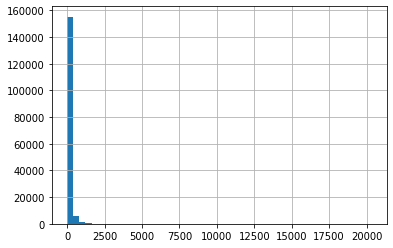

In [187]:
ratings_per_user = df_main.groupby('userId')['movieId'].count()

ratings_per_user.hist(bins=50)

In [188]:
# Convert Series to Dataframe for easier filtering.
ratings_per_user = pd.DataFrame({'userId':ratings_per_user.index, 'count':ratings_per_user.values})

In [189]:
ratings_per_user.shape[0] # 162.541 users

162541

The bast mayority of users have less than 20 reviews.

<AxesSubplot:>

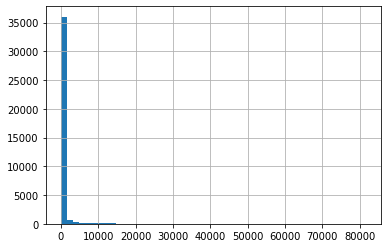

In [190]:
ratings_per_movie = df_main.groupby('movieId')['userId'].count()


ratings_per_movie.hist(bins=50)

In [191]:
# Convert Series to Dataframe for easier filtering.
ratings_per_movie = pd.DataFrame({'movieId':ratings_per_movie.index, 'count':ratings_per_movie.values})

In [193]:
ratings_per_movie.shape[0] # 37.972 movies with ratings.

37972

Most movies have less than 200 ratings.

For the data and noise reduction part, we'll eliminate films which have less than 30 reviews, as well as users who have voted less than 15 films.

In [194]:
# Keep ratings of users with more than 15 reviews in total.

# 1st, apply filter to grouped dataframes.
ratings_per_user = ratings_per_user[ratings_per_user['count'] >= 15]

ratings_per_movie = ratings_per_movie[ratings_per_movie['count'] >= 30]

In [195]:
ratings_per_user.shape[0] # 153.866 users left

153866

In [196]:
ratings_per_movie.shape[0] # 9.737 movies left

9737

In [198]:
# Now delete filtered ratings.
df_ratings = df_main[
    (df_main['userId'].isin(ratings_per_user['userId'])) &
    (df_main['movieId'].isin(ratings_per_movie['movieId']))
    ]

In [199]:
df_ratings.shape # 16.903.579 ratings left.

(16903579, 3)

In [ ]:
df_ratings.head(1)

,userId,movieId,rating
0,23564,115629,3.0


In [208]:
df_json = df_ratings.to_json(orient="records")
parsed = json.loads(df_json)

with open("datasets/final/ratings_final.json", "w", encoding="utf-8") as f:
    json.dump(parsed, f, indent=4)

In [112]:
df_json = df_main.to_json(orient="records")
parsed = json.loads(df_json)

with open("datasets/final/ratings_final.json", "w", encoding="utf-8") as f:
    json.dump(parsed, f, indent=4)

# 3. Average rating, std & number of ratings by film.

In [209]:
import pandas as pd
import numpy as np
import json

In [210]:
df_films = pd.read_json("datasets/final/movies_final.json", orient="records")
df_rt = pd.read_json("datasets/final/ratings_final.json", orient="records")

In [211]:
df_films.head(1)

,movieId,title,genres,year,titleType,director,writer,genre_0,genre_1,genre_2
0,1,Toy Story,"[adventure, animation, children]",1995,movie,John Lasseter,John Lasseter,adventure,animation,children


In [212]:
# Create columns 'mean' and 'std'
df_films['vote_average'] = np.NaN
df_films['vote_std'] = np.NaN
df_films['vote_count'] = np.NaN

In [213]:
df_films.shape[0]

40609

In [214]:
df_rt.shape[0]

16903579

In [215]:
df_rt[df_rt['movieId'] == 296]['rating'].mean()

4.1886911757191765

In [216]:
# Define functions to calculate mean and std.
def calculate_mean(x):
    return df_rt[df_rt['movieId'] == x]['rating'].mean()

def calculate_std(x):
    return df_rt[df_rt['movieId'] == x]['rating'].std()

def count_votes(x):
    return df_rt[df_rt['movieId'] == x].count()

In [217]:
df_films['vote_average'] = df_films['movieId'].apply(calculate_mean)

In [218]:
df_films['vote_std'] = df_films['movieId'].apply(calculate_std)

In [223]:
df_films['vote_count'] = df_films['movieId'].apply(count_votes)

In [224]:
df_films.isnull().sum()

movieId             0
title               0
genres              0
year                0
titleType           0
director            0
writer              0
genre_0             0
genre_1         19149
genre_2         31577
vote_average    30872
vote_std        30872
vote_count          0
dtype: int64

In [225]:
# We will drop the films with no reviews.
df_films = df_films[df_films.notna()]

In [226]:
df_films.shape[0]

40609

In [227]:
df_json = df_films.to_json(orient="records")
parsed = json.loads(df_json)

with open("datasets/final/movies_final.json", "w", encoding="utf-8") as f:
    json.dump(parsed, f, indent=4)

In [228]:
# We have to update the reviews dataset.
df_rt = pd.read_json("datasets/final/ratings_final.json", orient="records")

df_rt = df_rt[df_rt['movieId'].isin(df_films['movieId'])]

df_json = df_rt.to_json(orient="records")
parsed = json.loads(df_json)

with open("datasets/final/ratings_final.json", "w", encoding="utf-8") as f:
    json.dump(parsed, f, indent=4)



In [229]:
df_rt.shape[0]  # 16.903.579

16903579

---

# 4. Reduced datasets

## 50%

In [230]:
df_films = pd.read_json("datasets/final/movies_final.json", orient="records")

# 1st, reduce the films dataset.
#df_films = pd.read_json("datasets/final/movies_final.json", orient="records")

df_films.shape[0]

40609

In [231]:
df_films = df_films.sample(frac=0.50)

df_films.shape[0]

20304

In [232]:
df_json = df_films.to_json(orient="records")
parsed = json.loads(df_json)

with open("datasets/final/movies_reduced_50.json", "w", encoding="utf-8") as f:
    json.dump(parsed, f, indent=4)

In [233]:
df_rt = pd.read_json("datasets/final/ratings_final.json", orient="records")


# Now ratings dataset
#df_rt = pd.read_json("datasets/final/ratings_final.json", orient="records")

df_rt.shape[0]

16903579

In [234]:
df_rt = df_rt[df_rt['movieId'].isin(df_films['movieId'])]

df_rt.shape[0]

8702017

In [235]:
df_json = df_rt.to_json(orient="records")
parsed = json.loads(df_json)

with open("datasets/final/ratings_reduced_50.json", "w", encoding="utf-8") as f:
    json.dump(parsed, f, indent=4)

## 25%

In [236]:
import pandas as pd
import json

In [237]:
# 1st, reduce the films dataset.
df_films = pd.read_json("datasets/final/movies_final.json", orient="records")

df_films = df_films.sample(frac=0.25)


df_json = df_films.to_json(orient="records")
parsed = json.loads(df_json)

with open("datasets/final/movies_reduced_25.json", "w", encoding="utf-8") as f:
    json.dump(parsed, f, indent=4)

In [238]:
# Now ratings dataset
df_rt = pd.read_json("datasets/final/ratings_final.json", orient="records")

df_rt = df_rt[df_rt['movieId'].isin(df_films['movieId'])]

df_rt.shape[0]  # 4.128.014

4128014

In [239]:
# Even with the reduced dataset there are
# way too many ratings for our computing power.
# That's why it is reduced even more.
df_rt = df_rt.sample(frac=0.15)

df_json = df_rt.to_json(orient="records")
parsed = json.loads(df_json)

with open("datasets/final/ratings_reduced_25.json", "w", encoding="utf-8") as f:
    json.dump(parsed, f, indent=4)

In [240]:
df_rt.shape[0]

619202

---

# 5. Encoding

Noninal attributes have to be encoded for the algorithms to work. One-hot encoding is tipically used for nominal attributes, but the increment in dimensionality (+24 dimensions) is deemed to be too high. Thus, we've opted for a label encoding, which would otherwise be more suitable for ordinal string attributes.

In [241]:
# Libraries
import pandas as pd
import numpy as np
import json

# Encoding + normalization.
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from pickle import dump # To save and read binaries of models and scalers


In [242]:
# We're mainly working with the smaller dataset.
df_movies = pd.read_json("datasets/final/movies_reduced_25.json", orient="records")

In [243]:
# dict holding the column name and its respective encoder.
encoder_dict = {}

## Title

In [145]:
# Label encoding. 'le' variable is used for later decoding.
le = LabelEncoder()
df_movies['title'] = le.fit_transform(df_movies['title'])

# Add encoder to dict
encoder_dict['title'] = le

df_movies.head(2)

,movieId,title,genres,year,titleType,director,writer,genre_0,genre_1,genre_2,vote_average,vote_std,vote_count
0,7329,4297,[drama],1962,movie,Edward Dmytryk,Nelson Algren,drama,None,None,2.916667,1.241639,6
1,163304,1287,[drama],2014,movie,Najwa Najjar,Najwa Najjar,drama,None,None,2.500000,1.414214,2


## Genres

As we can see bellow, there are 20 different genres. (With this smaller number we can try to apply the one-hot encoding method.) Label encoding will be used as 1-hot adds too many dimensions and computational complexity.

In [146]:
df_movies['genres'].explode().unique()

array(['drama', 'adventure', 'horror', 'mystery', 'thriller', 'romance',
       'crime', 'action', 'comedy', 'sci-fi', 'animation', 'war',
       'musical', 'children', 'fantasy', 'documentary',
       '(no genres listed)', 'western', 'film-noir', 'imax'], dtype=object)

### One-hot encoding (NOT USED)

In [147]:
# PREVIOUS!!

# # One-hot encoder.
# enc = OneHotEncoder(handle_unknown='ignore')

# # Fitting requires a 2D array. Reshape converts our 1D array into 2D.
# arr = np.array(df_movies['genres'].explode().unique()).reshape(-1,1)

# enc.fit(arr)

# # Add encoder to dict
# encoder_dict['genres'] = enc

In [148]:
# PREVIOUS!!

# # Example of transformation and inverse transformation.
# tr = enc.transform([['action'], ['adventure']]).toarray()
# tr

In [149]:
# PREVIOUS!!

# enc.inverse_transform(tr)

In [150]:
# PREVIOUS!!

# # Applying one-hot encoding to each row in genres.

# # 1st, define function to apply:
# def one_hot_encode(x, enc):
#     """
#     Encodes a 1D array using one-hot encoding.

#     Some 
#     Parameters
#     ---------- 
#     x : 1D list of parameters to encode.
#     enc : already defined one-hot encoder.
        
#     Returns
#     -------
#     1D array containing the encoding.
#     """
#     arr = enc.transform(np.array(x).reshape(-1,1)).toarray()
    
#     # sum: [[0,1,0,0], [1,0,0,0]] -> [1,1,0,0].
#     return sum(arr)

# # Now that we're at it, a decoding function should be defined as well.
# def one_hot_decode(x, enc):
#     """
#     Decodes a 1D vector using one-hot encoding.

#     Parameters
#     ---------- 
#     x : 2D vectori with previously encoded parameters.
#     enc : already defined one-hot encoder.

#     Returns
#     -------
#     1D array containing the decoded parameters.
#     """
#     # TODO: transformation to 2D array and posterior decoding.
#     return np.array(enc.inverse_transform(x)).flatten()

In [151]:
# PREVIOUS!!

#df_movies['genres'] = df_movies['genres'].apply(one_hot_encode, enc=enc)

In [152]:
# PREVIOUS!!

#df_movies['genres'].head(200)[2]

### Label encoding

In [153]:
def label_encoder(x, encoder):
    return encoder.transform([x])[0]

# TODO: check this works.
def label_decoder(x, encoder):
    return encoder.inverse_transform(x)

In [154]:
# Label encoding. 'le' variable is used for later decoding.
le = LabelEncoder()
le.fit(
    np.append(df_movies['genres'].explode().unique(), None)
    )
df_movies['genre_0'] = df_movies['genre_0'].apply(label_encoder, encoder=le)
df_movies['genre_1'] = df_movies['genre_1'].apply(label_encoder, encoder=le)
df_movies['genre_2'] = df_movies['genre_2'].apply(label_encoder, encoder=le)


# Add encoder to dict
encoder_dict['genres'] = le

df_movies.head(2)

,movieId,title,genres,year,titleType,director,writer,genre_0,genre_1,genre_2,vote_average,vote_std,vote_count
0,7329,4297,[drama],1962,movie,Edward Dmytryk,Nelson Algren,8,20,20,2.916667,1.241639,6
1,163304,1287,[drama],2014,movie,Najwa Najjar,Najwa Najjar,8,20,20,2.500000,1.414214,2


## Movie type

In [155]:
df_movies['titleType'].explode().unique()

array(['movie', 'short', 'tvShort', 'tvMovie'], dtype=object)

### One-hot encoding

In similar fasion to 'genres', one-hot encoding is not used in the end.

In [156]:
# # One-hot encoder.
# enc = OneHotEncoder(handle_unknown='ignore')

# # Fitting requires a 2D array. Reshape converts our 1D array into 2D.
# arr = np.array(df_movies['titleType'].explode().unique()).reshape(-1,1)

# enc.fit(arr)

# # Add encoder to dict
# encoder_dict['titleType'] = enc

In [157]:
# df_movies['titleType'] = df_movies['titleType'].apply(one_hot_encode, enc=enc)

### Label encoding

In [158]:
# Label encoding. 'le' variable is used for later decoding.
le = LabelEncoder()
df_movies['titleType'] = le.fit_transform(df_movies['titleType'])

# Add encoder to dict
encoder_dict['titleType'] = le

df_movies.head(2)


df_movies['titleType'] = le.fit_transform(df_movies['titleType'])


## Directors

In [159]:
len(df_movies['director'].explode().unique())

3495

In [160]:
le = LabelEncoder()
df_movies['director'] = le.fit_transform(df_movies['director'])

# Add encoder to dict
encoder_dict['director'] = le

df_movies.head(2)

,movieId,title,genres,year,titleType,director,writer,genre_0,genre_1,genre_2,vote_average,vote_std,vote_count
0,7329,4297,[drama],1962,0,890,Nelson Algren,8,20,20,2.916667,1.241639,6
1,163304,1287,[drama],2014,0,2344,Najwa Najjar,8,20,20,2.500000,1.414214,2


## Writers

In [161]:
len(df_movies['writer'].explode().unique())

3952

In [162]:
le = LabelEncoder()
df_movies['writer'] = le.fit_transform(df_movies['writer'])

# Add encoder to dict
encoder_dict['writer'] = le

df_movies.head(2)

,movieId,title,genres,year,titleType,director,writer,genre_0,genre_1,genre_2,vote_average,vote_std,vote_count
0,7329,4297,[drama],1962,0,890,2687,8,20,20,2.916667,1.241639,6
1,163304,1287,[drama],2014,0,2344,2652,8,20,20,2.500000,1.414214,2


In [163]:
# Checking that all encoders have been added to the dict
encoder_dict

{'title': LabelEncoder(),
 'genres': LabelEncoder(),
 'titleType': LabelEncoder(),
 'director': LabelEncoder(),
 'writer': LabelEncoder()}

In [164]:
# Drop movieId and genres column
df_movies.drop(['movieId', 'genres'], axis=1, inplace=True)

In [165]:
# Save encoders.
for k,v in encoder_dict.items():
    dump(v, open(f'encoders & scalers/encoder_{k}','wb'))

# 6. Normalization

In [166]:
# For each column, normalize its data and save the scaler.
for col in df_movies.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    arr = np.array(df_movies[col]).reshape(-1,1)
    scaler.fit(arr)
    df_movies[col] = scaler.transform(arr)
    dump(scaler, open(f'encoders & scalers/scaler_{col}','wb'))


In [167]:
df_movies.head(1)

,title,year,titleType,director,writer,genre_0,genre_1,genre_2,vote_average,vote_std,vote_count
0,0.952983,0.971782,0.0,0.254722,0.680081,0.421053,1.0,1.0,0.537037,0.390209,0.00028


# 7. Save final vectorized dataset

In [168]:
df_json = df_movies.to_json(orient="records")
parsed = json.loads(df_json)

with open("datasets/vectorized/movies_vectorized_25.json", "w", encoding="utf-8") as f:
    json.dump(parsed, f, indent=4)

In [170]:
print(f"The whole preprocessing process takes {(time.time()-t0)/60} minutes to execute.")

The whole preprocessing process took 15.2203631122907 minutes to execute.


---